# Arima Modelling

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, bascially its own lags and the lagged forecast errors.

In [59]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [36]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

### ARIMA Formula

General Form:
y' = intercept + lags(AR) + errors(MA)

### Read Data

In [19]:
df = pd.read_csv('nasdaq_weekly.csv', index_col = 'Date', parse_dates = True)
df = df.dropna()
data = df['Close']
print('Shape of data:', data.shape)
data.head()

Shape of data: (2644,)


Date
1971-02-01    100.000000
1971-02-08    102.050003
1971-02-15    100.699997
1971-02-22    101.339996
1971-03-01    103.000000
Name: Close, dtype: float64

Plot your data

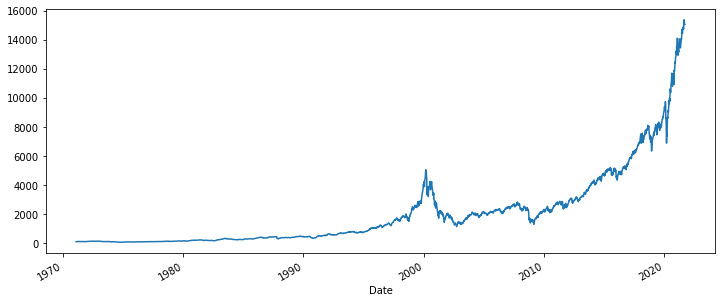

In [27]:
data.plot(figsize=(12,5))

## Part 1: Fitting the entire data set

### Check for Stationarity

The Augmented Dickey Fuller (ADF) Test is used to check if the prices series is stationary.

The null hypothesis of the ADF test that the time series is non-stationary.So if the P-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and say that the time series is indeed stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF: ", dftest[0])
    print("2. P-Value: ", dftest[1])
    print("3. Num of Lags: ", dftest[2])
    print("4. Num of observations used for ADF Regression and Critical values calculations: ", dftest[3])
    print("5. Critical Values: ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)
    

In [23]:
ad_test(df['Close'])

1. ADF:  5.0292362152092815
2. P-Value:  1.0
3. Num of Lags:  26
4. Num of observations used for ADF Regression and Critical values calculations:  2617
5. Critical Values: 
	 1% :  -3.4328512326377636
	 5% :  -2.86264505301087
	 10% :  -2.567358258833187


The P-value is 1.0 and therefore it is not stationary. We need to fint the order of differencing

### Autocorrelation Function (ACF)

In [14]:
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

C:\Users\Cl3rity\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


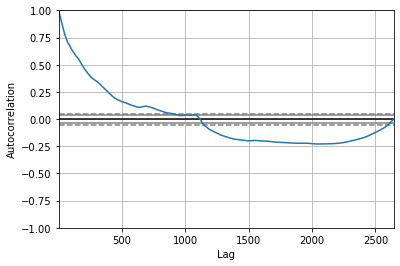

In [22]:
autocorrelation_plot(data)

There is a positive correlation with the first 1000 to 1100 lags that is most significant for the first 500 lags.
With this information, we will start the AR parameter of the model at 500.

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

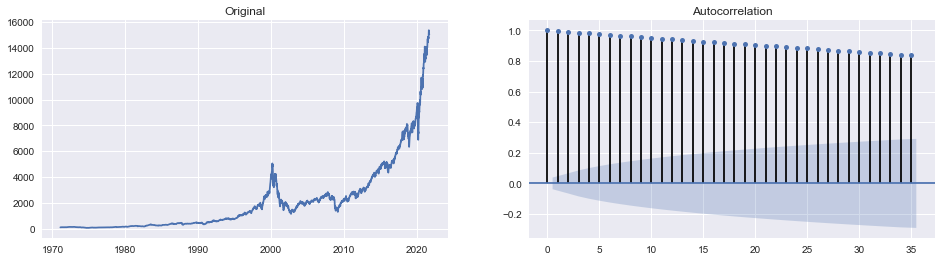

In [38]:
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(16,4))

ax1.plot(data)
ax1.set_title("Original")
# add; at the end of the plot function so that the plot is not duplicated
plot_acf(data, ax=ax2);

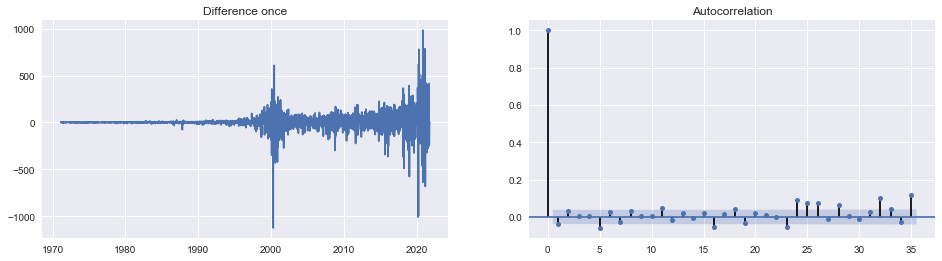

In [42]:
diff = data.diff().dropna()

fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

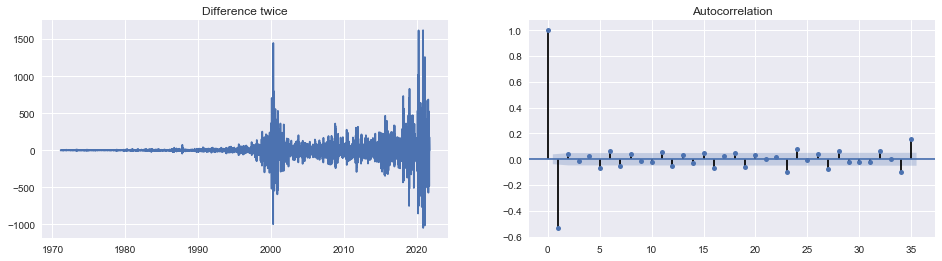

In [43]:
#differencing the data twice
diff = data.diff().diff().dropna()

fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);

The autocorrelation after differencing twice goes into a deep negative as compared to after differencing once. From these observations, we will likely opt for differencing once.
We can use the pmdarima package to get the number of differencing as well...

In [45]:
from pmdarima.arima.utils import ndiffs

In [46]:
ndiffs(data, test='adf')

1

This tool also came to the same conclusion of only differencing once

From the differencing order (d) that has already been figured out to be 1, we can move on to find out the order for the Auto Regeressive (AR) term. It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf

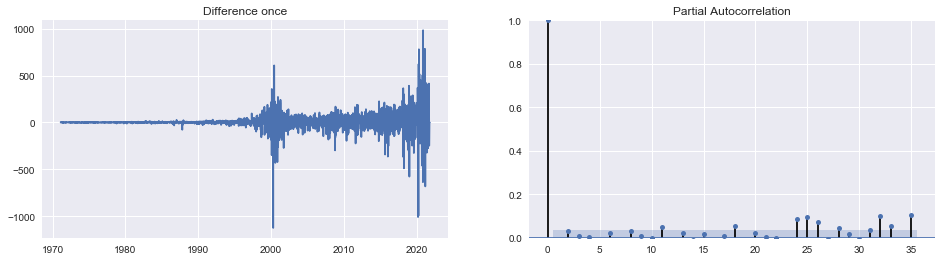

In [51]:
diff = data.diff().dropna()

fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 11 and many other >20 numbers are above the significance line. For this round, we will be using 11.

The next term is q. It is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

For this, we look at the ACF plot for the number of MA terms.

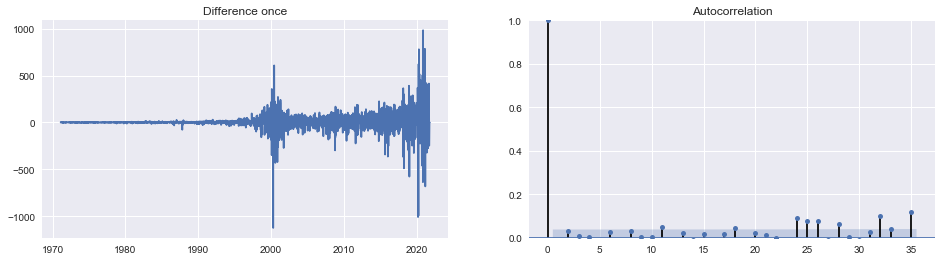

In [52]:
diff = data.diff().dropna()

fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

From the autocorrelation graph above, we can select 11 as the q term as well

### Fitting the ARIMA Model

In [53]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(data, order=(11,1,11))
result = model.fit(disp=0) # setting it to 0 so that the convergence info doesn't print

In [54]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2643
Model:               ARIMA(11, 1, 11)   Log Likelihood              -15752.700
Method:                       css-mle   S.D. of innovations             93.052
Date:                Sun, 26 Sep 2021   AIC                          31553.401
Time:                        18:18:33   BIC                          31694.513
Sample:                             1   HQIC                         31604.486
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6978     32.202      0.177      0.860     -57.417      68.812
ar.L1.D.Close      0.9435      0.015     64.783      0.000       0.915       0.972
ar.L2.D.Close     -0.2333      0.019

([array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00504624, 0.        , 0.        , 0.        , 0.        ]),
  array([0.        ,

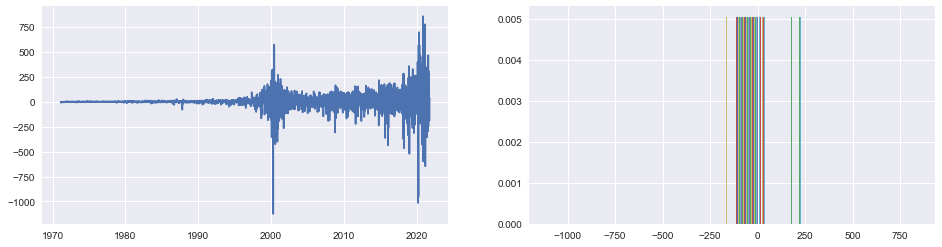

In [56]:
# PLot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

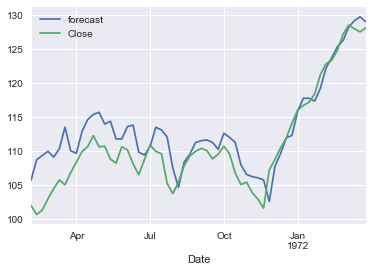

In [58]:
# Actual vs Fitted
result.plot_predict(
    start = 1,
    end = 60,
    dynamic = False
);

## Part 2: Using the historical prices to predict future prices

In [64]:
dataset = df[["Close"]].copy()

In [65]:
dataset.describe()

,Close
count,2644.000000
mean,2076.262550
std,2699.116495
min,55.160000
25%,250.862499
50%,1139.044983
75%,2577.262451
max,15363.519531


### Train-Test Split

In [68]:
# use 90% for the training set and 10% for the test set
n = int(len(df) * 0.9)
train = dataset.Close[:n]
test = dataset.Close[n:]

In [69]:
print(len(train))
print(len(test))

2379
265


For this exercise, we will be using the p,d and q terms that had been found in Part 1.

In [70]:
model = ARIMA(train, order=(11,1,11))
result = model.fit(disp=0)

In [71]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2378
Model:               ARIMA(11, 1, 11)   Log Likelihood              -13111.943
Method:                       css-mle   S.D. of innovations             59.927
Date:                Sun, 26 Sep 2021   AIC                          26271.885
Time:                        18:46:02   BIC                          26410.462
Sample:                    02-08-1971   HQIC                         26322.323
                         - 08-29-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9618      0.691      2.839      0.005       0.608       3.316
ar.L1.D.Close      0.1364      0.081      1.694      0.090      -0.021       0.294
ar.L2.D.Close     -0.2555      0.072     -3.544      0.000      -0.397      -0.114
ar.L3.D.Close      0.3947      0.044      8.923      0.000       0.308       0.481
ar.L4.D.Close     -0.0027      0.047     -0.058      0.954      -0.094       0.089
ar.L5.D.Close     -0.3398      0.053     -6.447      0.000      -0.443      -0.237
ar.L6.D.Close      0.2503      0.066      3.786      0.000       0.121       0.380
ar.L7.D.Close      0.0932      0.046      2.009      0.044       0.002       0.184
ar.L8.D.Close     -0.3651      0.041     -9.006      0.000      -0.445      -0.286
ar.L9.D.Close      0.3231      0.063      5.147      0.000       0.200       0.446
ar.L10.D.Close    -0.0622      0.080     -0.781      0.435      -0.218       0.094
ar.L11.D.Close     0.7977      0.037     21.372      0.000       0.725       0.871
ma.L1.D.Close     -0.1727      0.075     -2.315      0.021      -0.319      -0.026
ma.L2.D.Close      0.2897      0.073      3.979      0.000       0.147       0.432
ma.L3.D.Close     -0.4217      0.048     -8.773      0.000      -0.516      -0.328
ma.L4.D.Close      0.0627      0.050      1.249      0.212      -0.036       0.161
ma.L5.D.Close      0.3937      0.044      8.890      0.000       0.307       0.481
ma.L6.D.Close     -0.2492      0.073     -3.393      0.001      -0.393      -0.105
ma.L7.D.Close     -0.1602      0.044     -3.617      0.000      -0.247      -0.073
ma.L8.D.Close      0.3682      0.042      8.816      0.000       0.286       0.450
ma.L9.D.Close     -0.3795      0.059     -6.433      0.000      -0.495      -0.264
ma.L10.D.Close     0.1297      0.083      1.554      0.120      -0.034       0.293
ma.L11.D.Close    -0.8469      0.043    -19.476      0.000      -0.932      -0.762
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0031           -0.0000j            1.0031           -0.0000
AR.2             0.8543           -0.5381j            1.0096           -0.0895
AR.3             0.8543           +0.5381j            1.0096            0.0895
AR.4             0.4227           -0.9424j            1.0329           -0.1829
AR.5             0.4227           +0.9424j            1.0329            0.1829
AR.6            -0.9621           -0.3170j            1.0130           -0.4493
AR.7            -0.9621           +0.3170j            1.0130            0.4493
AR.8            -0.2737           -0.9715j            1.0094           -0.2937
AR.9            -0.2737           +0.9715j            1.0094            0.2937
AR.10           -0.5037           -0.9196j            1.

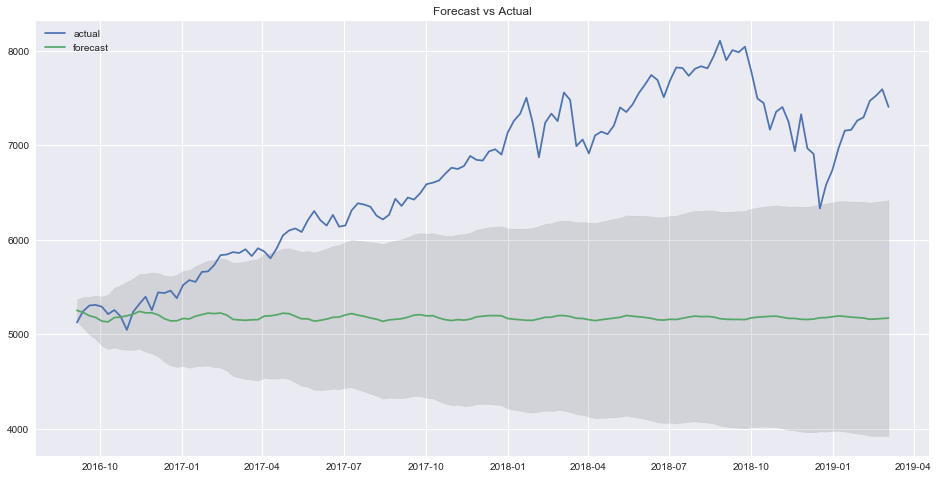

In [96]:
step = 131

fc, se, conf = result.forecast(step)

# fc - forecast, se - standard error, conf - confidence level

fc = pd.Series(fc, index = test[:step].index)
lower = pd.Series(conf[:,0], index=test[:step].index)
upper = pd.Series(conf[:,1], index=test[:step].index)

plt.figure(figsize=(16,8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

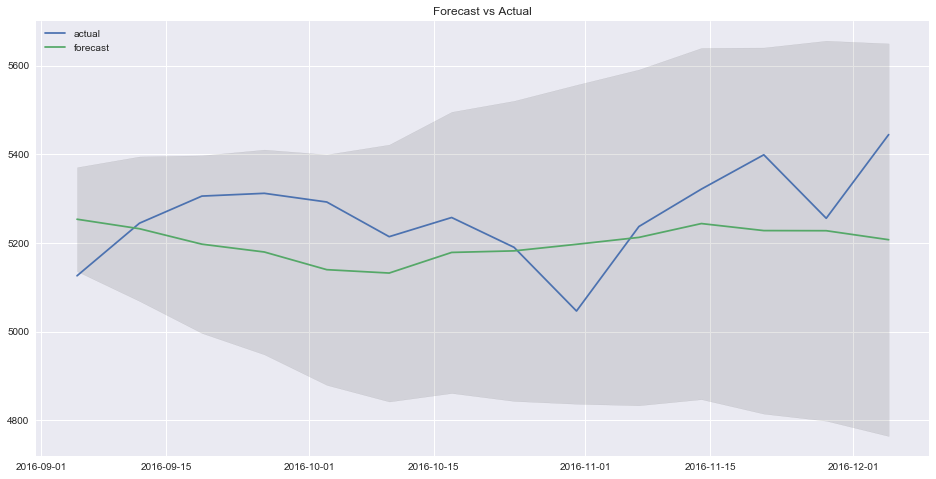

In [97]:
step = 14

fc, se, conf = result.forecast(step)

# fc - forecast, se - standard error, conf - confidence level

fc = pd.Series(fc, index = test[:step].index)
lower = pd.Series(conf[:,0], index=test[:step].index)
upper = pd.Series(conf[:,1], index=test[:step].index)

plt.figure(figsize=(16,8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")